<center><img src='https://drive.google.com/uc?id=1_utx_ZGclmCwNttSe40kYA6VHzNocdET' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center><img src='https://drive.google.com/uc?id=1BXZ0u3562N_MqCLcekI-Ens77Kk4LpPm'></center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej"
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

In this lab, you will implement some of the techniques discussed in the lecture.

Below you are given a solution to the previous scenario. Note that it has two serious drawbacks:
 * The output predictions do not sum up to one (i.e. it does not return a distribution) even though the images always contain exactly one digit.
 * It uses MSE coupled with output sigmoid which can lead to saturation and slow convergence

**Task 1.** Use softmax instead of coordinate-wise sigmoid and use log-loss instead of MSE. Test to see if this improves convergence. Hint: When implementing backprop it might be easier to consider these two function as a single block and not even compute the gradient over the softmax values.

**Task 2.** Implement L2 regularization and add momentum to the SGD algorithm. Play with different amounts of regularization and momentum. See if this improves accuracy/convergence.

**Task 3 (optional).** Implement Adagrad, dropout and some simple data augmentations (e.g. tiny rotations/shifts etc.). Again, test to see how these changes improve accuracy/convergence.

**Task 4.** Try adding extra layers to the network. Again, test how the changes you introduced affect accuracy/convergence. As a start, you can try this architecture: [784,100,30,10]


In [7]:
import random
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms


In [2]:
# Let's read the mnist dataset
# j != i derivative of sotfmax function = softmax(xi) * softmax(xj)
# if j == i it's softmax(xi)(1 - softmax(xi))

# derivative of cross entropy over xi -1/N (softmax(xi) - yi)
def load_mnist(path='.'):
    train_set = datasets.MNIST(path, train=True, download=True)
    x_train = train_set.data.numpy()
    _y_train = train_set.targets.numpy()

    test_set = datasets.MNIST(path, train=False, download=True)
    x_test = test_set.data.numpy()
    _y_test = test_set.targets.numpy()

    x_train = x_train.reshape((x_train.shape[0],28*28)) / 255.
    x_test = x_test.reshape((x_test.shape[0],28*28)) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

100%|██████████| 9912422/9912422 [00:00<00:00, 82364511.94it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5210585.59it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19243844.70it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3210943.67it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    # Derivative of the sigmoid
    return sigmoid(z)*(1-sigmoid(z))

def softmax(x):
    max_val = np.max(x)
    return np.exp(x - max_val - np.log(np.sum(np.exp(x - max_val), axis = 0)))


In [ ]:
class Network(object):
    """
    Baseline network with sigmoid activation function only.
    """
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.matmul(w, a)+b)
        return a

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        g = x
        gs = [g] # list to store all the gs, layer by layer
        fs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases, self.weights):
            f = np.dot(w, g)+b
            fs.append(f)
            g = sigmoid(f)
            gs.append(g)
        # backward pass <- both steps at once
        dLdg = self.cost_derivative(gs[-1], y)
        dLdfs = []
        for w,g in reversed(list(zip(self.weights,gs[1:]))):
            dLdf = np.multiply(dLdg,np.multiply(g,1-g))
            dLdfs.append(dLdf)
            dLdg = np.matmul(w.T, dLdf)

        dLdWs = [np.matmul(dLdf,g.T) for dLdf,g in zip(reversed(dLdfs),gs[:-1])]
        dLdBs = [np.sum(dLdf,axis=1).reshape(dLdf.shape[0],1) for dLdf in reversed(dLdfs)]
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        return (output_activations-y)

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accuracy = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accuracy.append(acc)
                print("Epoch: {0}, Accuracy: {1}".format(j, acc))
            else:
                print("Epoch: {0}".format(j))
        return accuracy

baseline_accuracies = []
for _ in range(5):
    network = Network([784, 100, 30,10])
    accuracy = network.SGD((x_train, y_train), epochs=100, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
    baseline_accuracies.append(accuracy)
baseline_accuracies = [np.array(acc) for acc in baseline_accuracies]
baseline_accuracies = np.array(baseline_accuracies)
np.save('accuracy_baseline_arch.npy', baseline_accuracies)

In [ ]:
class Network_soft(object):
    """
    Last activation function is softmax.
    """
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            z = np.matmul(w, a)+b
            a = sigmoid(z)

        return softmax(z)

    def update_mini_batch(self, mini_batch, eta):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.weights = [w-(eta/len(mini_batch[0]))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch[0]))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        a = x
        activations = [a] # list to store all the gs, layer by layer
        zs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, a)+b
            zs.append(z)
            a = sigmoid(z)
            activations.append(a)

        z = np.dot(self.weights[-1], a) + self.biases[-1]
        zs.append(z)
        a = softmax(z)
        activations.append(a)

        # backward pass <- both steps at once
        dLdz = self.cost_derivative(activations[-1], y)
        dLdzs = [dLdz]
        dLda = np.matmul(self.weights[-1].T, dLdz)

        for w,a in reversed(list(zip(self.weights[:-1],activations[1:-1]))):
          dLdz = np.multiply(dLda, np.multiply(a, 1 - a))
          dLdzs.append(dLdz)
          dLda = np.matmul(w.T, dLdz)

        dLdWs = [np.matmul(dLdz,a.T) for dLdz,a in zip(reversed(dLdzs),activations[:-1])]
        dLdBs = [np.sum(dLdz,axis=1).reshape(dLdz.shape[0],1) for dLdz in reversed(dLdzs)]

        #print(dLdWs)
        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        # return (output_activations-y)
        return output_activations - y

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        accuracy = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta)

            if test_data:
                acc = self.evaluate((x_test, y_test))
                accuracy.append(acc)
                print("Epoch: {0}, Accuracy: {1}".format(j, acc))
            else:
                print("Epoch: {0}".format(j))

        return accuracy

accuracies_softmax = []
for _ in range(5):
    network_soft = Network_soft([784,100, 30,10])
    accuracy_soft = network_soft.SGD((x_train, y_train), epochs=100, mini_batch_size=100, eta=3.0, test_data=(x_test, y_test))
    accuracies_softmax.append(accuracy_soft)

accuracies_softmax = [np.array(acc) for acc in accuracies_softmax]
accuracies_softmax = np.array(accuracies_softmax)
np.save('accuracies_softmax_arch.npy', accuracies_softmax)

In [ ]:
class Network_soft_l2(object):
    """
    Last activation function is softmax + L2 regularization and momentum.
    """
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

        self.momentum_w = [np.zeros(w.shape) for w in self.weights]
        self.momentum_b = [np.zeros(b.shape) for b in self.biases]

    def feedforward(self, a):
        # Run the network on a batch
        a = a.T
        for b, w in zip(self.biases, self.weights):
            z = np.matmul(w, a)+b
            a = sigmoid(z)

        return softmax(z)

    def update_mini_batch(self, mini_batch, eta, lam, gamma):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch which is as in tensorflow API.
        # eta is the learning rate
        nabla_b, nabla_w = self.backprop(mini_batch[0].T,mini_batch[1].T)

        self.momentum_w = [gamma*m + nw + lam*w
                        for w, nw, m in zip(self.weights, nabla_w, self.momentum_w)]
        self.weights = [w-(eta/len(mini_batch[0]))*m
                        for w, m in zip(self.weights, self.momentum_w)]

        self.momentum_b = [gamma*m + nb
                           for nb, m in zip(nabla_b, self.momentum_b)]

        self.biases = [b-(eta/len(mini_batch[0]))*m
                       for b, m in zip(self.biases, self.momentum_b)]

    def backprop(self, x, y):
        # For a single input (x,y) return a pair of lists.
        # First contains gradients over biases, second over weights.
        a = x
        activations = [a] # list to store all the gs, layer by layer
        zs = [] # list to store all the fs, layer by layer
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = np.dot(w, a)+b
            zs.append(z)
            a = sigmoid(z)
            activations.append(a)

        z = np.dot(self.weights[-1], a) + self.biases[-1]
        zs.append(z)
        a = softmax(z)
        activations.append(a)

        # backward pass <- both steps at once
        dLdz = self.cost_derivative(activations[-1], y)
        dLdzs = [dLdz]
        dLda = np.matmul(self.weights[-1].T, dLdz)

        for w,a in reversed(list(zip(self.weights[:-1],activations[1:-1]))):
          dLdz = np.multiply(dLda, np.multiply(a, 1 - a))
          dLdzs.append(dLdz)
          dLda = np.matmul(w.T, dLdz)

        dLdWs = [np.matmul(dLdz,a.T) for dLdz,a in zip(reversed(dLdzs),activations[:-1])]
        dLdBs = [np.sum(dLdz,axis=1).reshape(dLdz.shape[0],1) for dLdz in reversed(dLdzs)]

        return (dLdBs,dLdWs)

    def evaluate(self, test_data):
        # Count the number of correct answers for test_data
        pred = np.argmax(self.feedforward(test_data[0]),axis=0)
        corr = np.argmax(test_data[1],axis=1).T
        return np.mean(pred==corr)

    def cost_derivative(self, output_activations, y):
        # return (output_activations-y)
        return output_activations - y

    def SGD(self, training_data, epochs, mini_batch_size, eta, lam, gamma, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data

        accuracy = []
        for j in range(epochs):
            for i in range(x_train.shape[0] // mini_batch_size):
                x_mini_batch = x_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                y_mini_batch = y_train[(mini_batch_size*i):(mini_batch_size*(i+1))]
                self.update_mini_batch((x_mini_batch, y_mini_batch), eta, lam, gamma)
            if test_data:
                acc = self.evaluate((x_test, y_test))
                accuracy.append(acc)
                print("Epoch: {0}, Accuracy: {1}".format(j, acc))
            else:
                print("Epoch: {0}".format(j))
        return accuracy

accuracies_l2 = []
for _ in range(2):
    network_l2 = Network_soft_l2([784, 30 ,10])
    accuracy_l2 = network_l2.SGD((x_train, y_train), epochs=100, mini_batch_size=100, eta=3.0, lam=0.01, gamma=0.3, test_data=(x_test, y_test))
    accuracies_l2.append(accuracy_l2)

accuracies_l2 = [np.array(acc) for acc in accuracies_l2]
accuracies_l2 = np.array(accuracies_l2)
np.save('accuracies_l2_03.npy', accuracies_l2)

In [32]:
accuracies_baseline = np.load('accuracy_baseline.npy')
accuracies_soft = np.load('accuracies_softmax.npy')
accuracies_l2 = np.load('accuracies_l2_07.npy')
accuracies_l2_03 = np.load('accuracies_l2_03.npy')

accuracies_baseline_a = np.load('accuracy_baseline_arch.npy')
accuracies_soft_a = np.load('accuracies_softmax_arch.npy')
accuracies_l2_a = np.load('accuracies_l2_arch_07.npy')
accuracies_l2_a_03 = np.load('accuracies_l2_arch_03.npy')

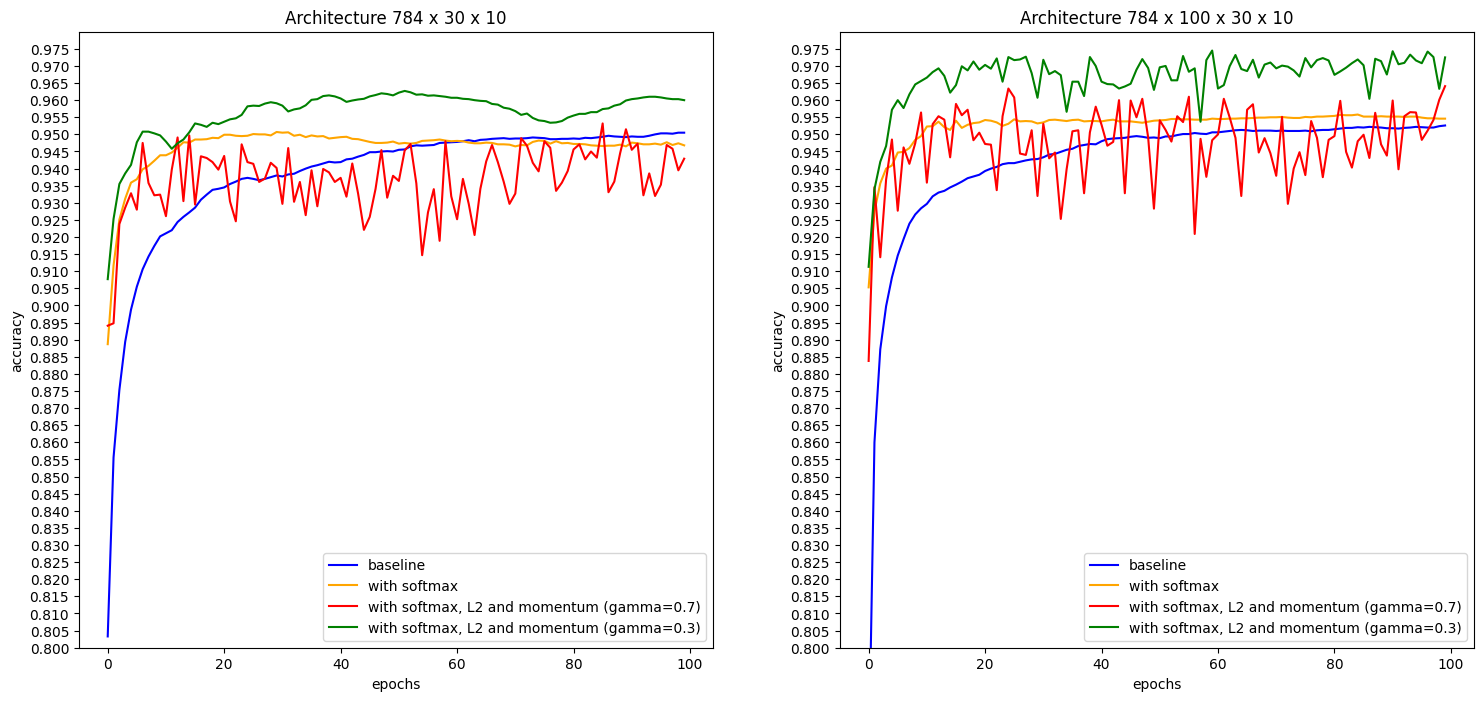

In [58]:
# initial architecture, eta=3, lamdba=0.01, gamma=0.7
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
ax[0].plot(range(100), accuracies_baseline[0], c='blue', label = 'baseline')
ax[0].plot(range(100), accuracies_soft[0], c='orange', label = 'with softmax')
ax[0].plot(range(100), accuracies_l2[0], c='red', label = 'with softmax, L2 and momentum (gamma=0.7)')
ax[0].plot(range(100), accuracies_l2_03[0], c='green', label = 'with softmax, L2 and momentum (gamma=0.3)')
ax[0].set_yticks(np.arange(0.8, 0.98, 0.005))
ax[0].set_ylim(0.8, 0.98)
ax[0].set_title('Architecture 784 x 30 x 10')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend()

ax[1].plot(range(100), accuracies_baseline_a[0], c='blue', label = 'baseline')
ax[1].plot(range(100), accuracies_soft_a[0], c='orange', label = 'with softmax')
ax[1].plot(range(100), accuracies_l2_a[0], c='red', label = 'with softmax, L2 and momentum (gamma=0.7)')
ax[1].plot(range(100), accuracies_l2_a_03[0], c='green', label = 'with softmax, L2 and momentum (gamma=0.3)')
ax[1].set_yticks(np.arange(0.8, 0.98, 0.005))
ax[1].set_ylim(0.8, 0.98)
ax[1].set_title('Architecture 784 x 100 x 30 x 10')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend()